In [79]:


import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]



     


In [80]:


df = pd.read_csv("creditcard.csv")



     


In [81]:


df.isnull().values.any()



     


False

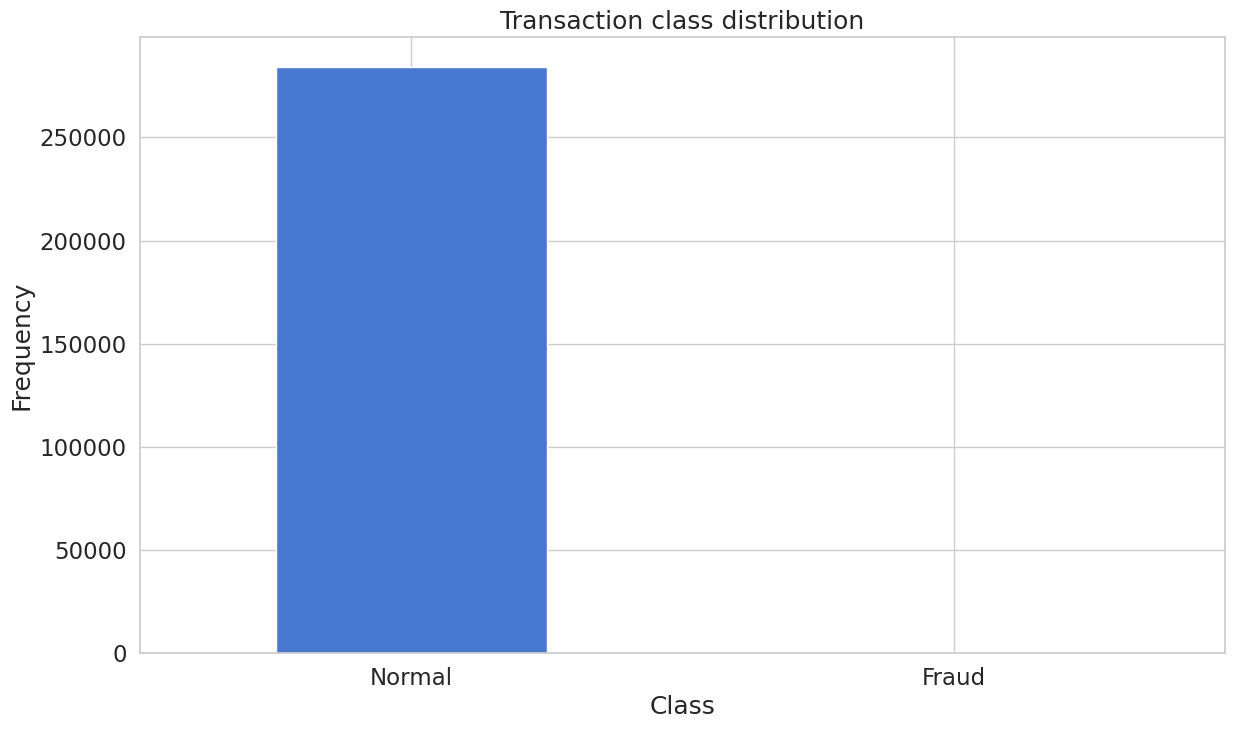

In [82]:


count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");



     


In [83]:


frauds = df[df.Class == 1]
normal = df[df.Class == 0]



     


frauds.shape



     


(492, 31)

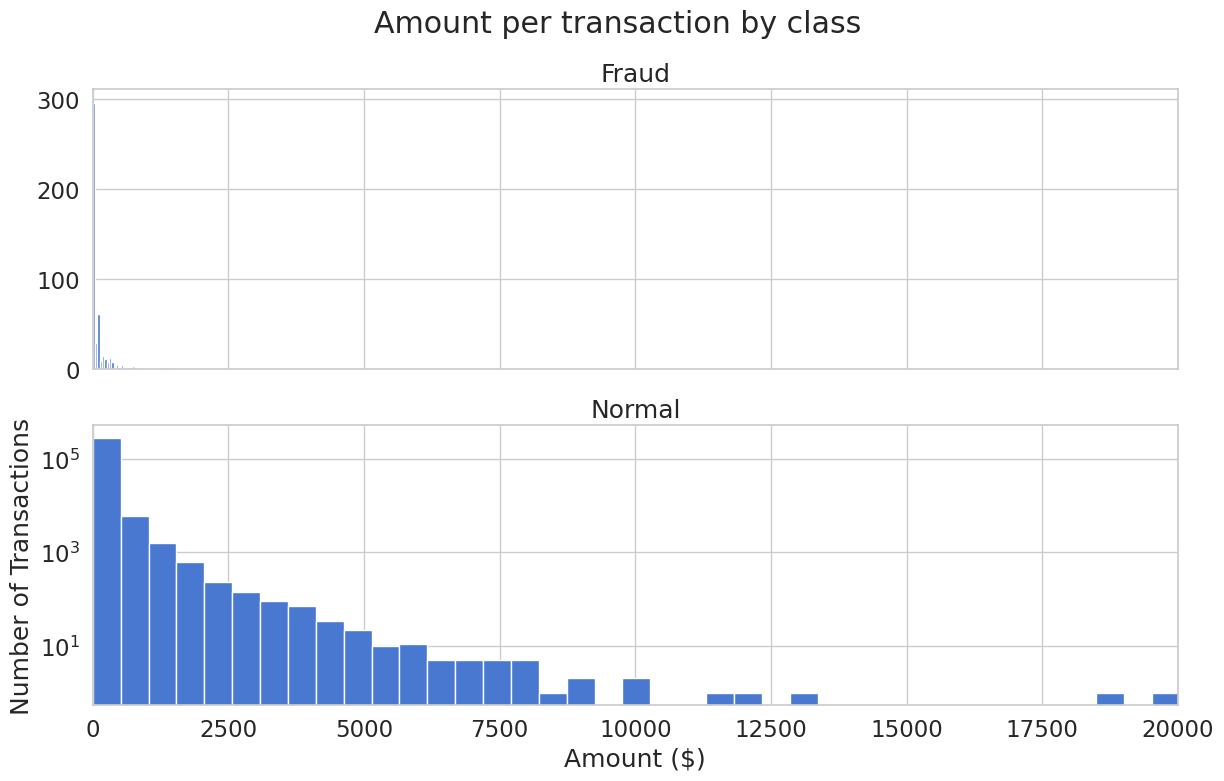

In [84]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

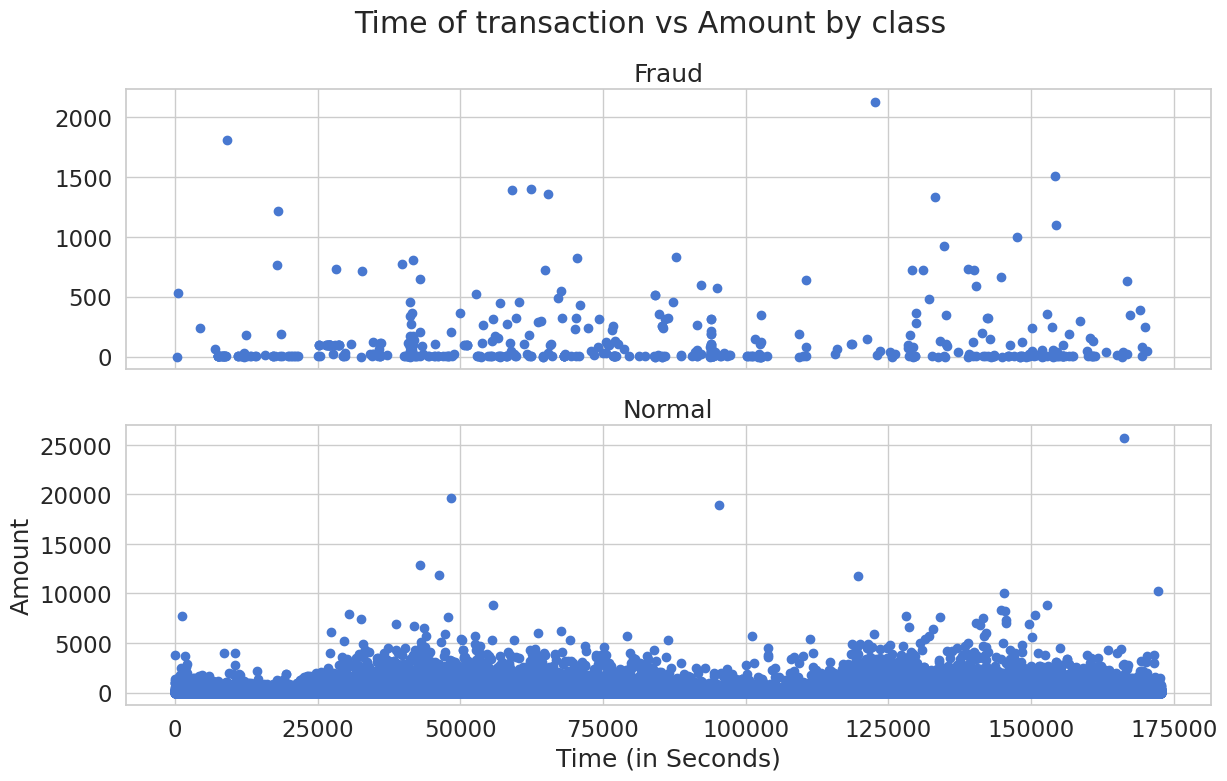

In [85]:


f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()



     


In [86]:


from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))



     


In [87]:


X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)

X_train, X_final = train_test_split(X_train, test_size=0.2, random_state=RANDOM_SEED)

out = X_test
out_f = X_final

y_train = X_train['Class']
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

y_final= X_final['Class']
X_final = X_final.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values
X_final = X_final.values


print(np.size(y_train))
print(np.size(y_final))
print(np.size(y_test))


     


182276
45569
56962


In [88]:


input_dim = X_train.shape[1]
encoding_dim = 14



     


In [89]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [90]:


nb_epoch = 10
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history



     


Epoch 1/10
5697/5697 [==============================] - 12s 2ms/step - loss: 0.8813 - accuracy: 0.5305 - val_loss: 0.7920 - val_accuracy: 0.6278
Epoch 2/10
5697/5697 [==============================] - 11s 2ms/step - loss: 0.8014 - accuracy: 0.6450 - val_loss: 0.7636 - val_accuracy: 0.6595
Epoch 3/10
5697/5697 [==============================] - 11s 2ms/step - loss: 0.7788 - accuracy: 0.6714 - val_loss: 0.7500 - val_accuracy: 0.6778
Epoch 4/10
5697/5697 [==============================] - 11s 2ms/step - loss: 0.7690 - accuracy: 0.6869 - val_loss: 0.7459 - val_accuracy: 0.6824
Epoch 5/10
5697/5697 [==============================] - 11s 2ms/step - loss: 0.7643 - accuracy: 0.6936 - val_loss: 0.7404 - val_accuracy: 0.6903
Epoch 6/10
5697/5697 [==============================] - 11s 2ms/step - loss: 0.7614 - accuracy: 0.6952 - val_loss: 0.7375 - val_accuracy: 0.7024
Epoch 7/10
5697/5697 [==============================] - 11s 2ms/step - loss: 0.7589 - accuracy: 0.6960 - val_loss: 0.7375 - val_ac

In [91]:


autoencoder = load_model('model.h5')



     


evaluation

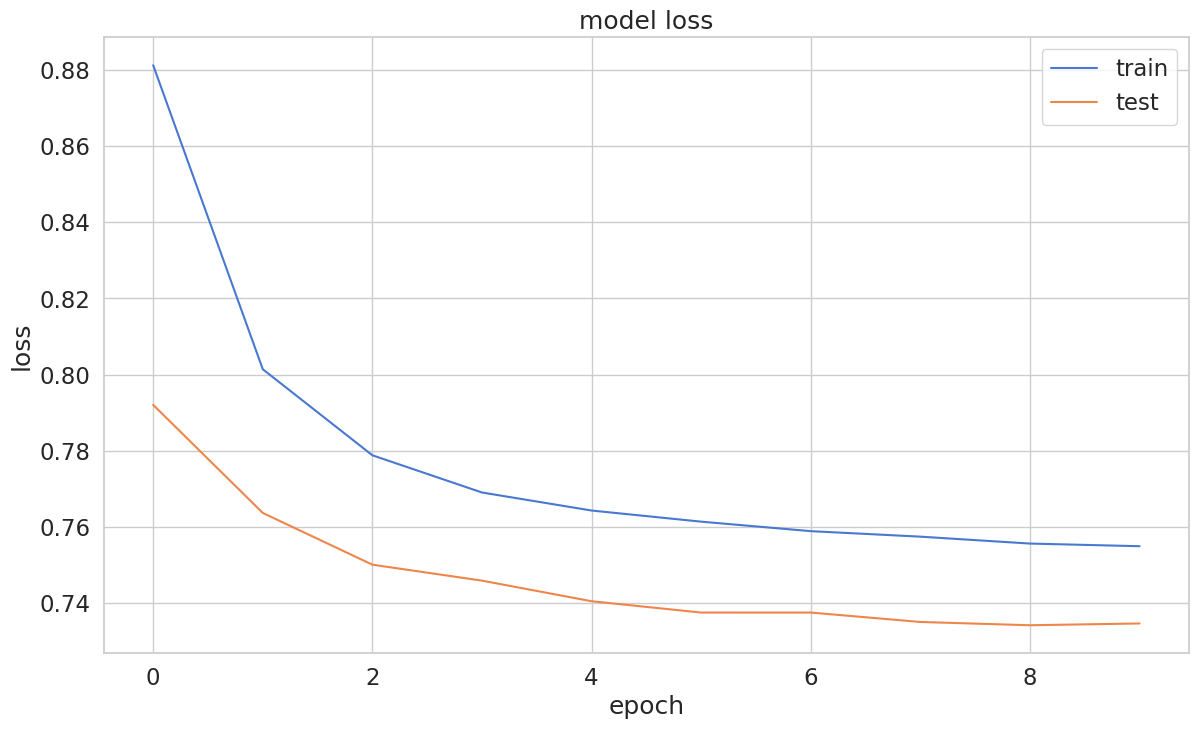

In [92]:


plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');



     


In [93]:


predictions = autoencoder.predict(X_test)



     


1781/1781 [==============================] - 2s 1ms/step


In [94]:


mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})



     


In [95]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

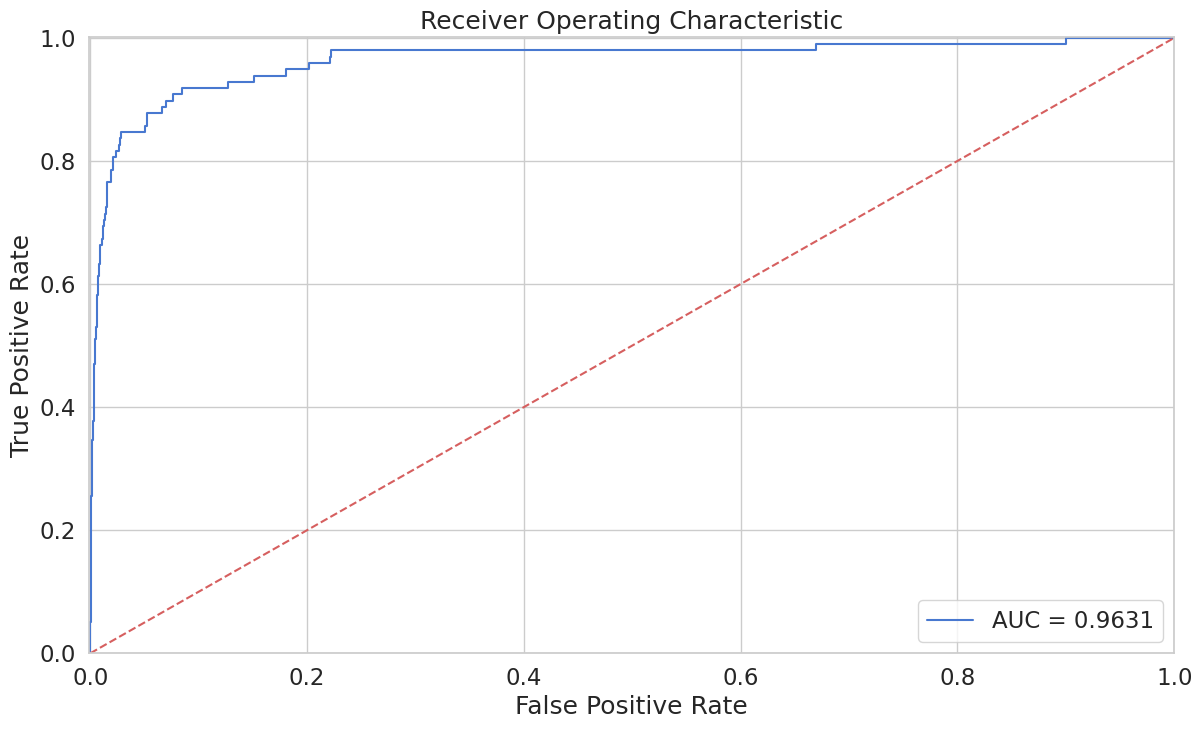

In [96]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

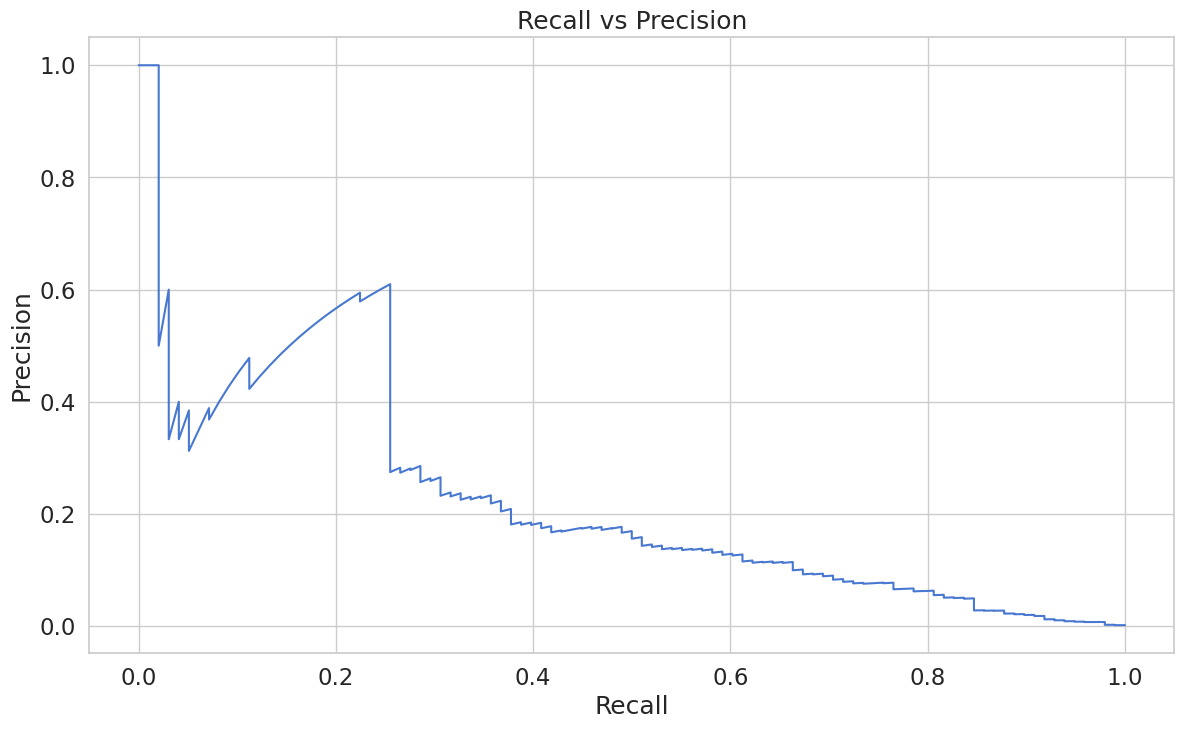

In [97]:


precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()



     


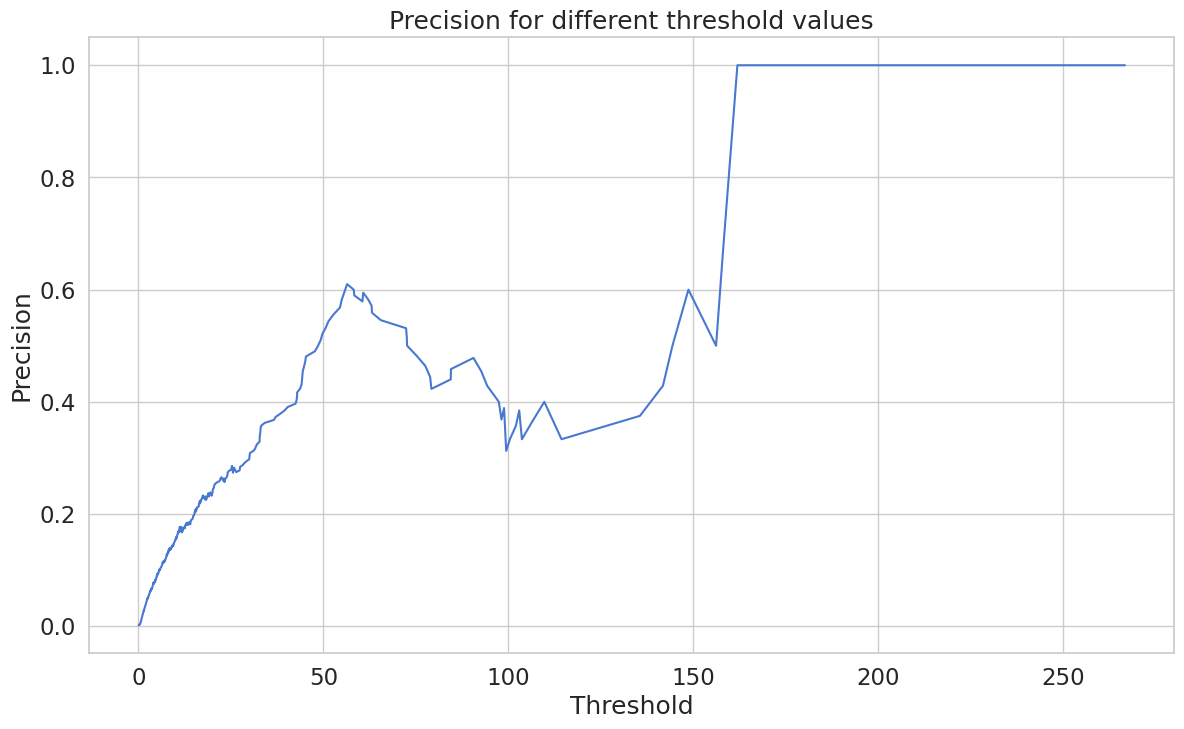

In [98]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

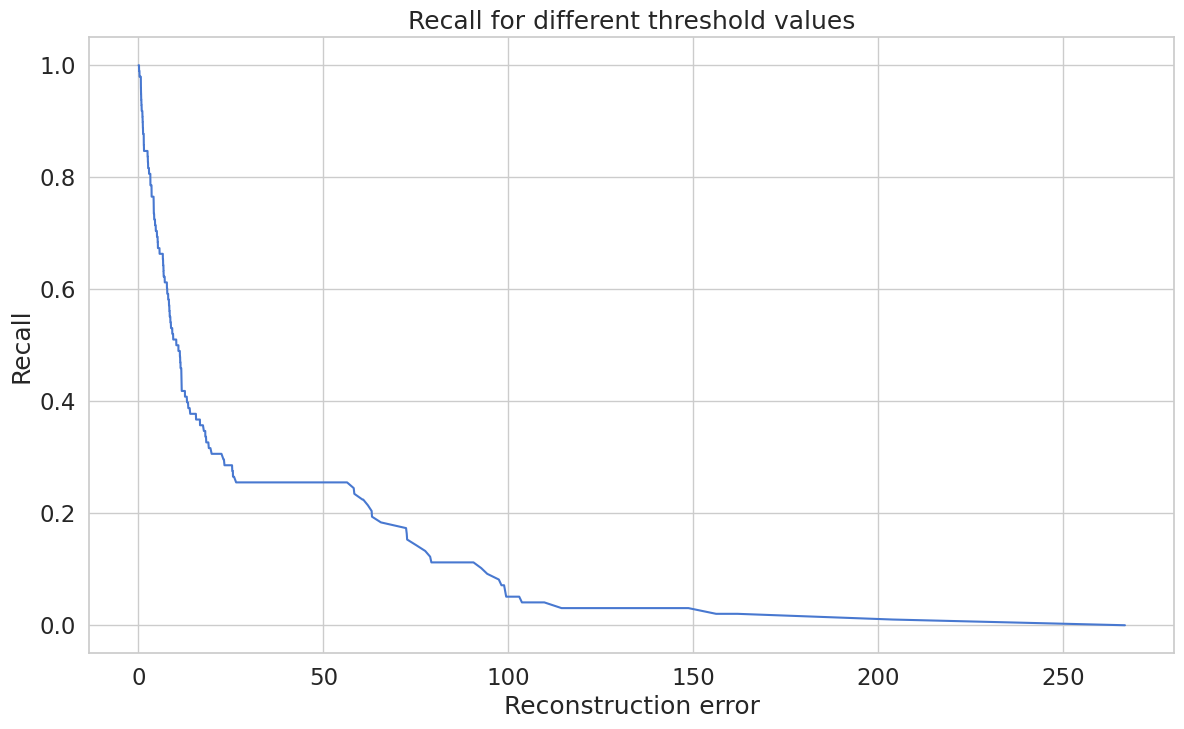

In [99]:


plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()



     


In [100]:


threshold = 2.9



     


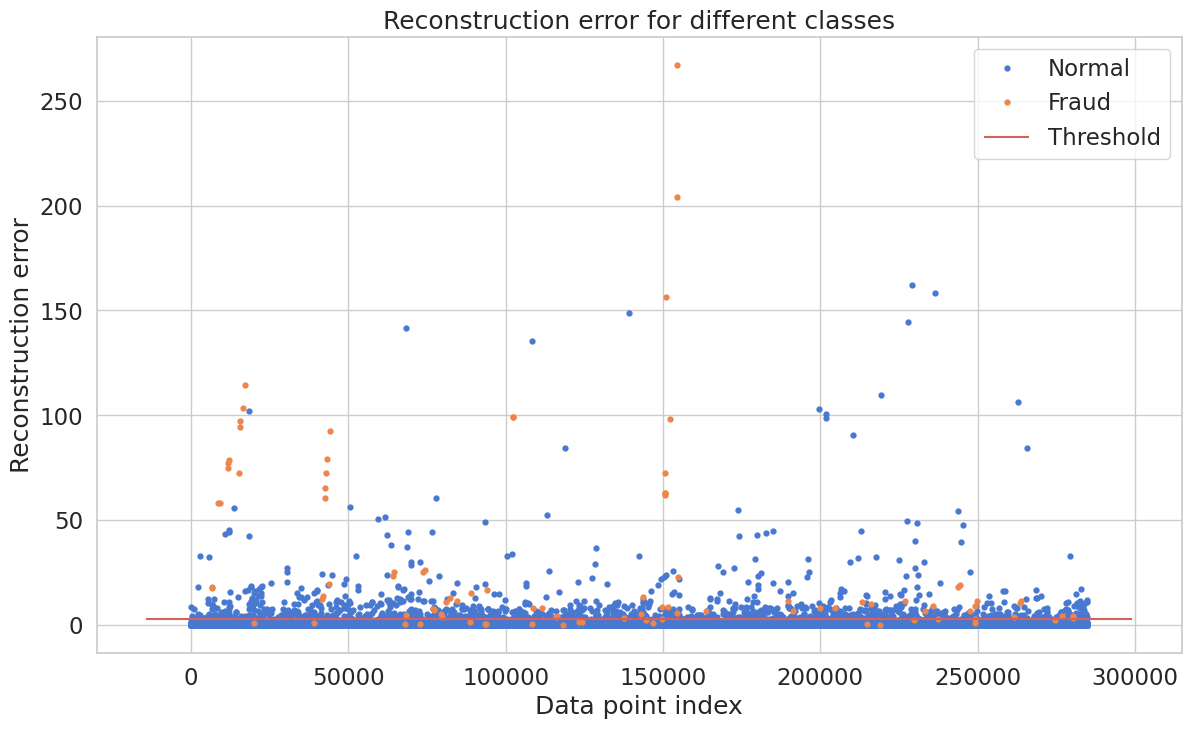

In [101]:


groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();



     


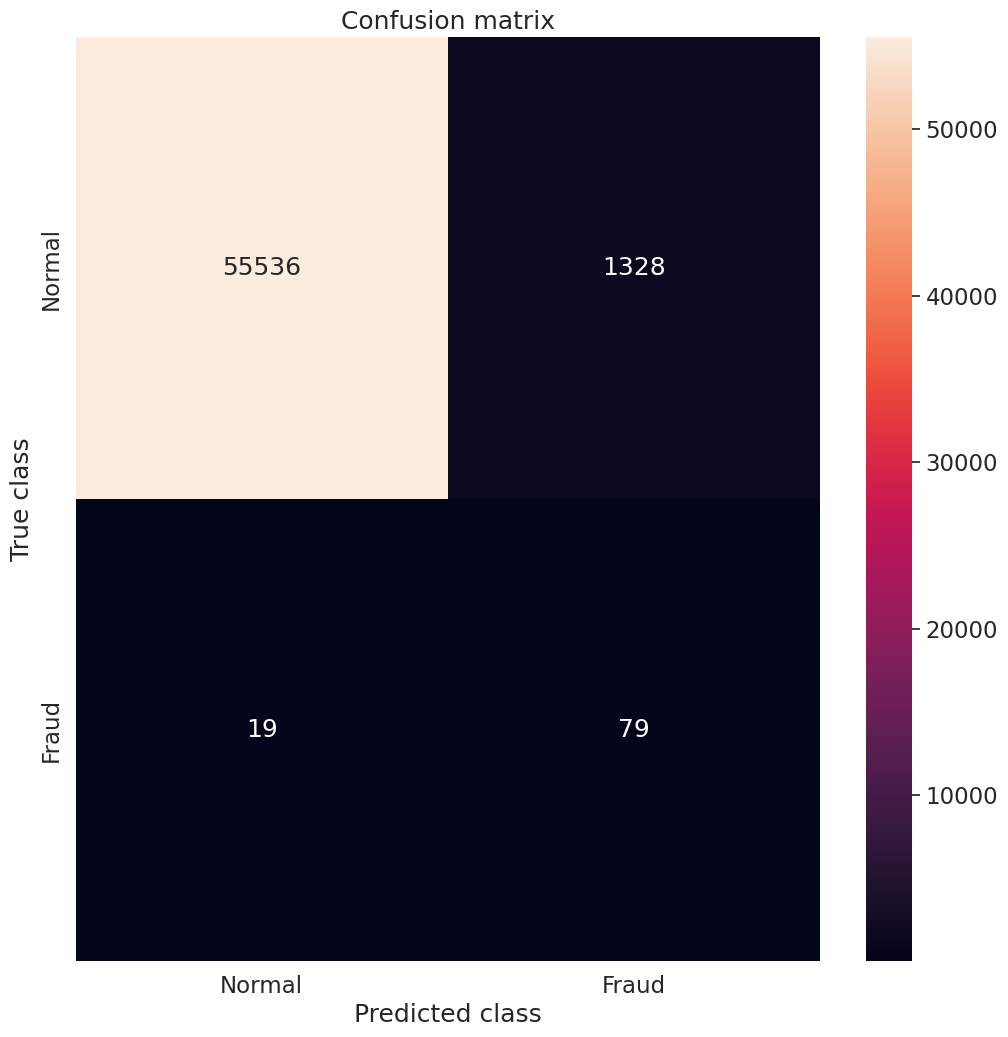

In [102]:


y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()



     


In [103]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [104]:
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)

Accuracy: 0.976353
Precision: 0.056148
Recall: 0.806122
F1 score: 0.104983


Accuracy: 0.976493
Precision: 0.056469
Recall: 0.806122
F1 score: 0.105544

for comparison purpose

In [105]:
predictions_f = autoencoder.predict(X_final)


1425/1425 [==============================] - 2s 1ms/step


In [106]:
mse_f = np.mean(np.power(X_final - predictions_f, 2), axis=1)
error_df_f = pd.DataFrame({'reconstruction_error': mse_f,
                        'true_class': y_final})

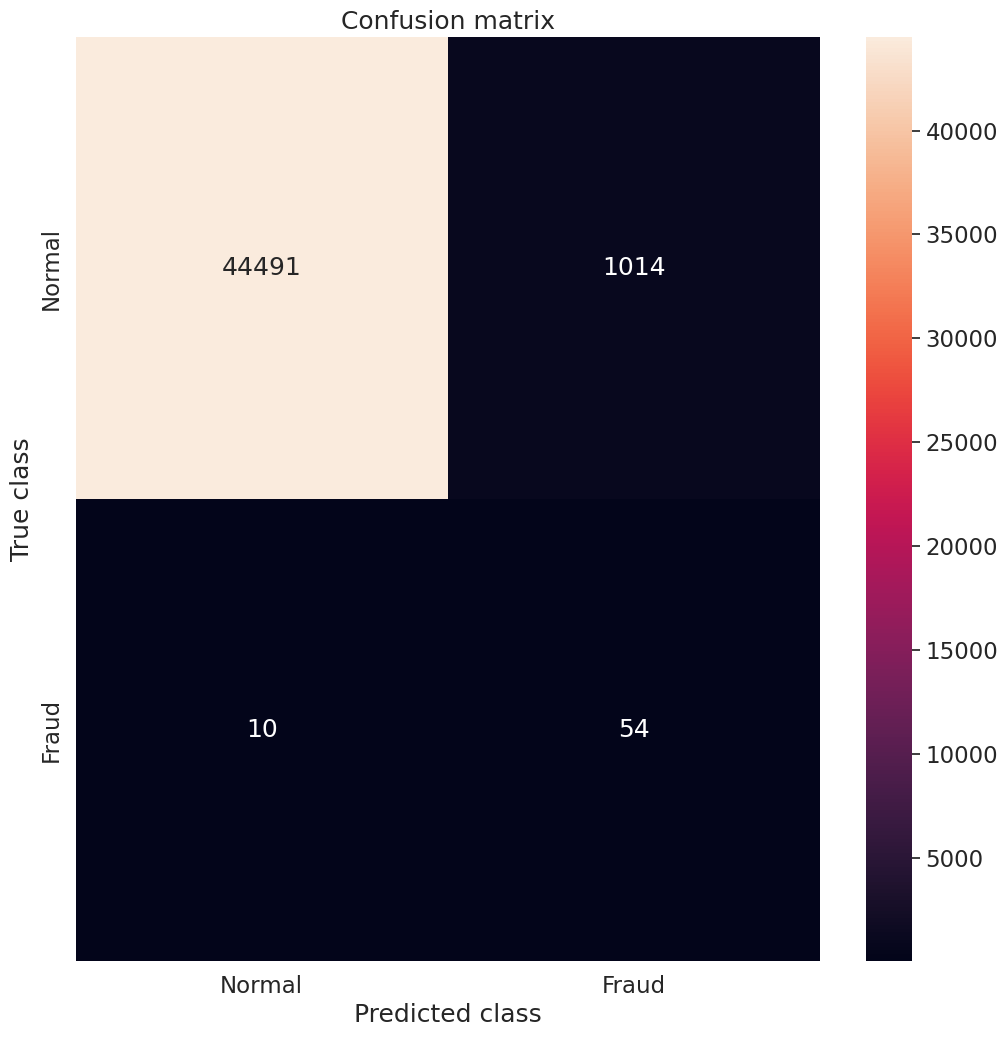

In [107]:
y_pred_f = [1 if e > threshold else 0 for e in error_df_f.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df_f.true_class, y_pred_f)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [108]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [109]:
accuracy = accuracy_score(y_final, y_pred_f)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_final, y_pred_f)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_final, y_pred_f)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_final, y_pred_f)
print('F1 score: %f' % f1)

Accuracy: 0.977529
Precision: 0.050562
Recall: 0.843750
F1 score: 0.095406


In [110]:
out_f['AEC']=y_pred_f

Accuracy: 0.977507
Precision: 0.050514
Recall: 0.843750
F1 score: 0.095322

supervised learning xgboost

In [111]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import pandas as pd
import numpy as np

In [112]:
xgboost = XGBClassifier(learning_rate =0.05,
 n_estimators=500,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,

 nthread=4,
 scale_pos_weight=1,
 seed=27).fit(X_train, y_train)

print('Cross Validation for XGBClassifier')
print(xgboost.score(X_test, y_test))



Cross Validation for XGBClassifier
0.9996488887328394


In [113]:
y_pred_xgb = xgboost.predict(X_test)

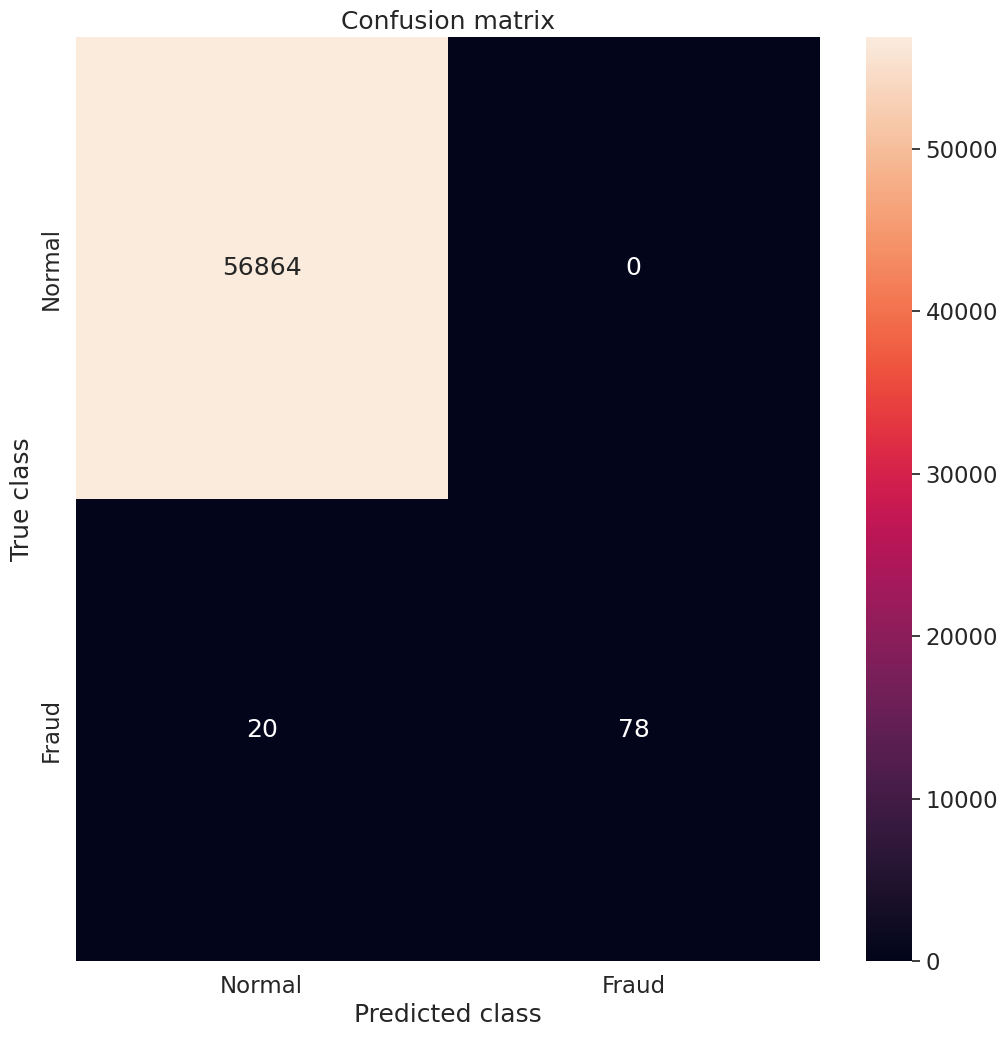

In [114]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

conf_matrix = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [115]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred_xgb)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred_xgb)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred_xgb)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred_xgb)
print('F1 score: %f' % f1)

Accuracy: 0.999649
Precision: 1.000000
Recall: 0.795918
F1 score: 0.886364


validation set

non:
Accuracy: 0.999649
Precision: 1.000000
Recall: 0.795918
F1 score: 0.886364

eval_metric='aucpr',
 

Accuracy: 0.999649
Precision: 1.000000
Recall: 0.795918
F1 score: 0.886364


In [116]:
y_pred_f_xgb = xgboost.predict(X_final)

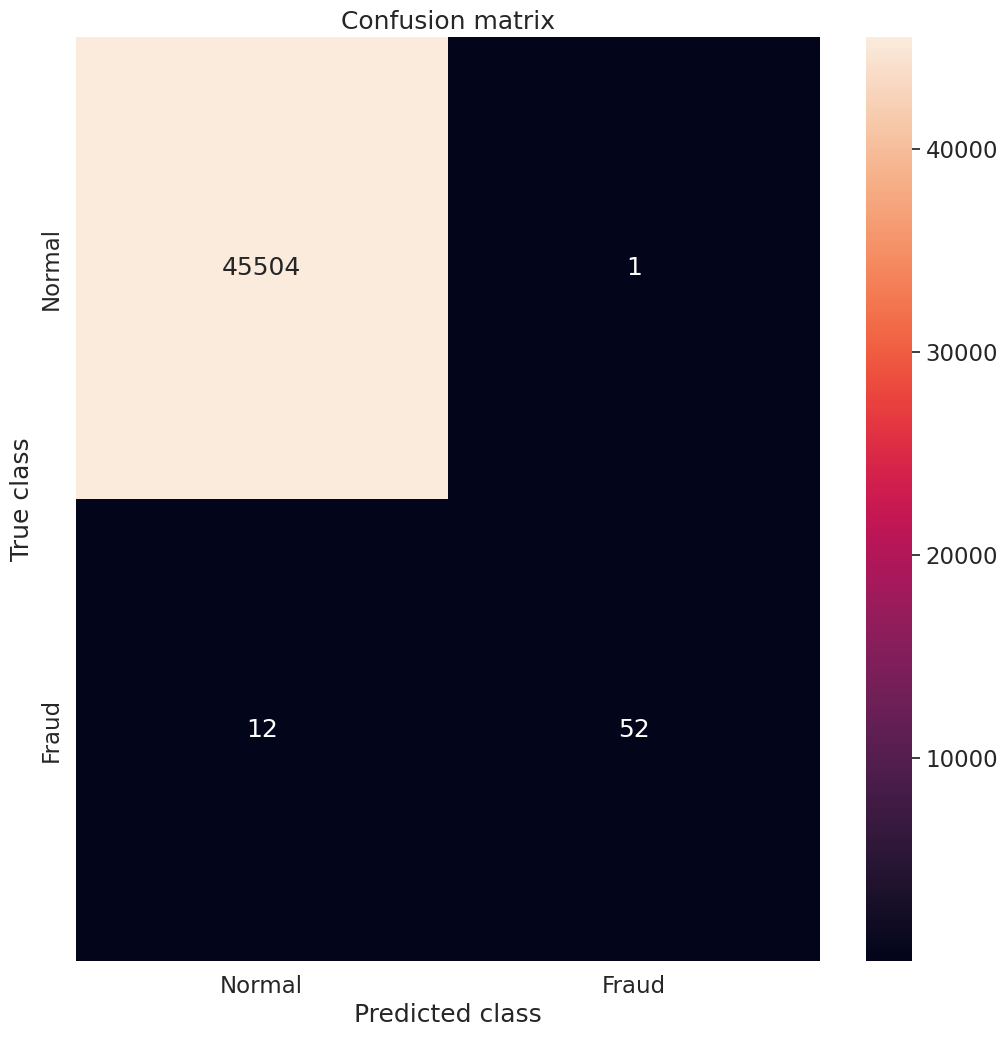

In [117]:
conf_matrix = confusion_matrix(y_final, y_pred_f_xgb)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [118]:
accuracy = accuracy_score(y_final, y_pred_f_xgb)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_final, y_pred_f_xgb)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_final, y_pred_f_xgb)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_final, y_pred_f_xgb)
print('F1 score: %f' % f1)

Accuracy: 0.999715
Precision: 0.981132
Recall: 0.812500
F1 score: 0.888889


In [119]:
out_f['xgb']=y_pred_f_xgb

for final set


Accuracy: 0.999715
Precision: 0.981132
Recall: 0.812500
F1 score: 0.888889

deep learning

In [120]:
import numpy as np
import tensorflow as tf

In [121]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=32, activation='relu', input_dim=X_train.shape[1]))
model.add(tf.keras.layers.Dense(units=16, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [122]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=[tf.keras.metrics.Recall()])

In [123]:
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
5697/5697 [==============================] - 10s 2ms/step - loss: 0.0098 - recall_1: 0.6848
Epoch 2/10
5697/5697 [==============================] - 9s 2ms/step - loss: 0.0033 - recall_1: 0.7788
Epoch 3/10
5697/5697 [==============================] - 9s 2ms/step - loss: 0.0029 - recall_1: 0.7667
Epoch 4/10
5697/5697 [==============================] - 9s 2ms/step - loss: 0.0027 - recall_1: 0.7727
Epoch 5/10
5697/5697 [==============================] - 9s 2ms/step - loss: 0.0025 - recall_1: 0.7576
Epoch 6/10
5697/5697 [==============================] - 9s 2ms/step - loss: 0.0024 - recall_1: 0.7848
Epoch 7/10
5697/5697 [==============================] - 10s 2ms/step - loss: 0.0024 - recall_1: 0.7697
Epoch 8/10
5697/5697 [==============================] - 10s 2ms/step - loss: 0.0023 - recall_1: 0.7970
Epoch 9/10
5697/5697 [==============================] - 10s 2ms/step - loss: 0.0021 - recall_1: 0.7727
Epoch 10/10
5697/5697 [==============================] - 10s 2ms/step - loss: 

In [124]:
y_pred_dl = model.predict(X_test)

1781/1781 [==============================] - 2s 1ms/step


In [125]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 32)                960       
                                                                 
 dense_12 (Dense)            (None, 16)                528       
                                                                 
 dense_13 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,505
Trainable params: 1,505
Non-trainable params: 0
_________________________________________________________________


In [126]:
a = y_pred_dl>=0.5
b = a.astype(int)
y_pred_dl=b
print(np.unique(y_pred_dl))

[0 1]


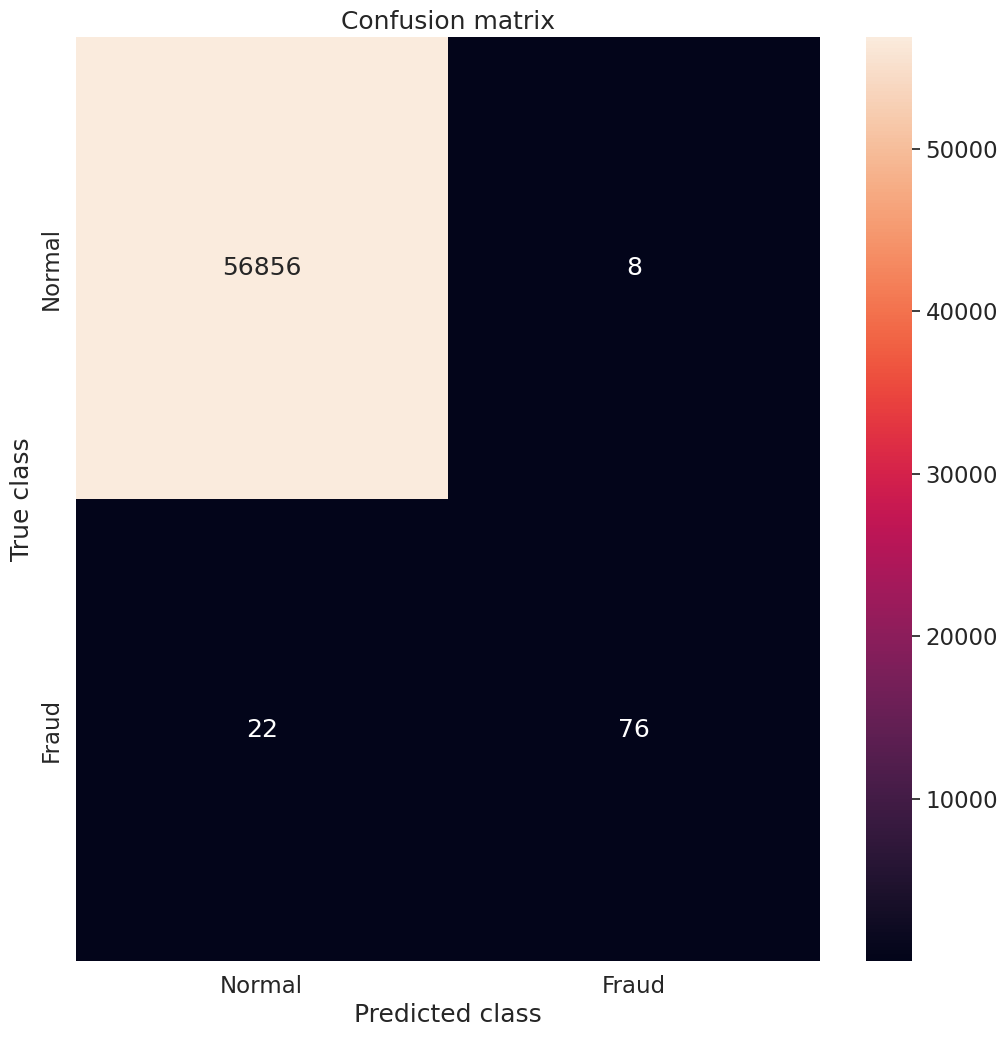

In [127]:
conf_matrix = confusion_matrix(y_test, y_pred_dl)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [128]:
accuracy = accuracy_score(y_test, y_pred_dl)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred_dl)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred_dl)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred_dl)
print('F1 score: %f' % f1)

Accuracy: 0.999473
Precision: 0.904762
Recall: 0.775510
F1 score: 0.835165


for validation set

3 layers 

non

Accuracy: 0.999473
Precision: 0.861702
Recall: 0.826531
F1 score: 0.843750


metrics=[tf.keras.metrics.Recall(thresholds=0)]

Accuracy: 0.999596
Precision: 0.931034
Recall: 0.826531
F1 score: 0.875676

metrics=[tf.keras.metrics.Recall()]


In [129]:
y_pred_f_dl = model.predict(X_final)
a = y_pred_f_dl>=0.5
b = a.astype(int)
y_pred_f_dl=b
print(np.unique(y_pred_f_dl))

1425/1425 [==============================] - 2s 1ms/step
[0 1]


In [130]:
accuracy = accuracy_score(y_final, y_pred_f_dl)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_final, y_pred_f_dl)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_final, y_pred_f_dl)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_final, y_pred_f_dl)
print('F1 score: %f' % f1)

Accuracy: 0.999583
Precision: 0.894737
Recall: 0.796875
F1 score: 0.842975


In [131]:
out_f['dl']=y_pred_f_dl
out_f.to_csv('out_f.csv')

In [132]:
out['AEC']=y_pred
out['xgb']=y_pred_xgb
out['dl']=y_pred_dl

out.to_csv('out.csv')

In [133]:
import pandas as pd

out=pd.read_csv('out.csv')

y_pred_xgb=out['xgb']
y_pred_dl=out['dl']


In [134]:
c = y_pred_dl + y_pred_xgb
a = (c/2)>=0.5
b = a.astype(int)
y_pred_ensemble=b

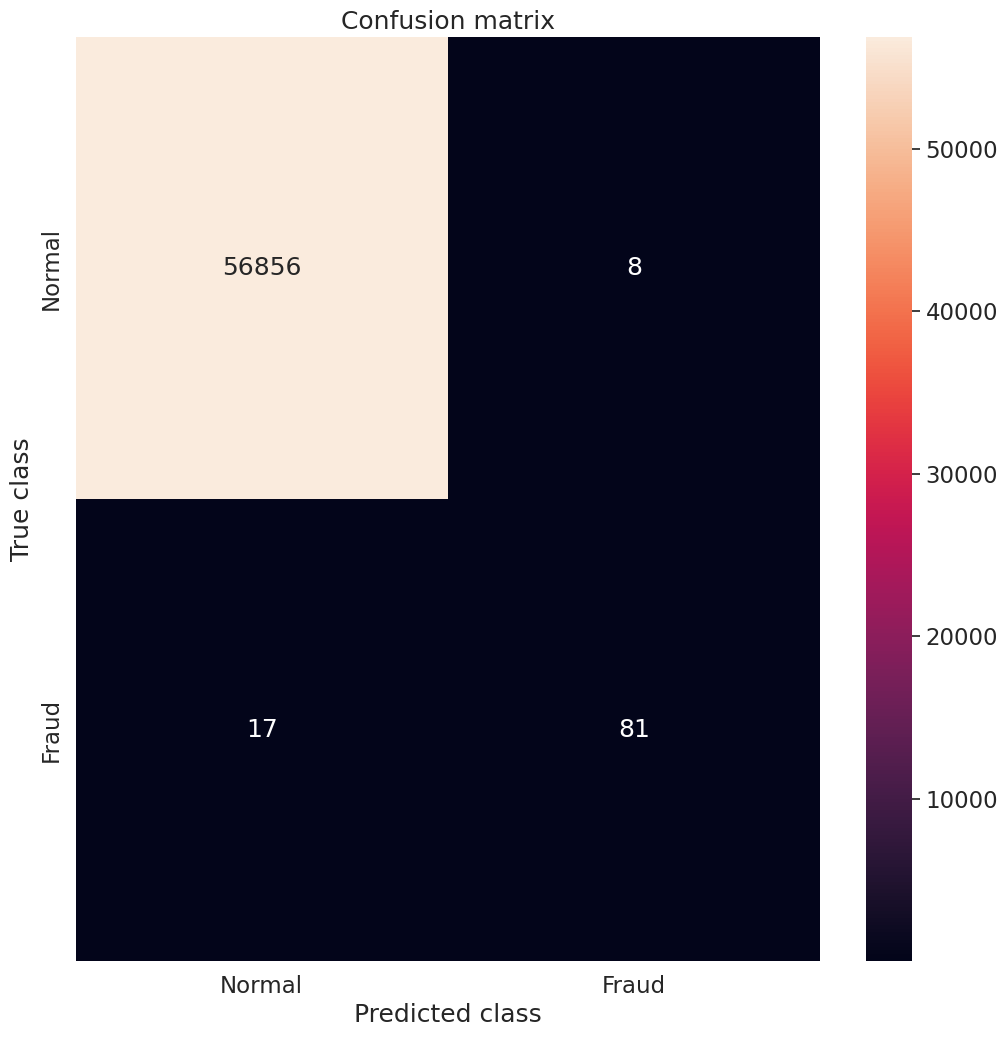

In [135]:
conf_matrix = confusion_matrix(y_test, y_pred_ensemble)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [136]:
accuracy = accuracy_score(y_test, y_pred_ensemble)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred_ensemble)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred_ensemble)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred_ensemble)
print('F1 score: %f' % f1)

Accuracy: 0.999561
Precision: 0.910112
Recall: 0.826531
F1 score: 0.866310


ensemble 2

>=
Accuracy: 0.999438
Precision: 0.830000
Recall: 0.846939
F1 score: 0.838384

>

Accuracy: 0.999596
Precision: 1.000000
Recall: 0.765306
F1 score: 0.867052

In [137]:
import pandas as pd

out=pd.read_csv('out.csv')

y_pred_xgb=out['xgb']
y_pred_dl=out['dl']
y_pred=out['AEC']

In [138]:
c = y_pred_dl + y_pred_xgb +y_pred
a = (c/3)>=0.5
b = a.astype(int)
y_pred_ensemble=b

In [139]:
accuracy = accuracy_score(y_test, y_pred_ensemble)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred_ensemble)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred_ensemble)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred_ensemble)
print('F1 score: %f' % f1)

Accuracy: 0.999508
Precision: 0.906977
Recall: 0.795918
F1 score: 0.847826


In [140]:
out=pd.read_csv('out.csv')
out['ensemble']= y_pred_ensemble

out.to_csv('out.csv')

ensemble 3

Accuracy: 0.999491
Precision: 0.879121
Recall: 0.816327
F1 score: 0.846561

validation set

Accuracy: 0.999614
Precision: 0.931818
Recall: 0.836735
F1 score: 0.881720

final set

In [141]:
import pandas as pd

out=pd.read_csv('out_f.csv')

y_pred_xgb=out['xgb']
y_pred_dl=out['dl']
y_pred=out['AEC']

In [142]:
c = y_pred_dl + y_pred_xgb
a = (c/2)>=0.5
b = a.astype(int)
y_pred_ensemble=b

In [143]:
accuracy = accuracy_score(y_final, y_pred_ensemble)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_final, y_pred_ensemble)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_final, y_pred_ensemble)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_final, y_pred_ensemble)
print('F1 score: %f' % f1)

Accuracy: 0.999649
Precision: 0.887097
Recall: 0.859375
F1 score: 0.873016


In [144]:
# c = y_pred_f_dl + y_pred_f_xgb
# a = (c/2)>=0.5
# b = a.astype(int)
# y_pred_f_ensemble=b

In [145]:
# accuracy = accuracy_score(y_final, y_pred_f_ensemble)
# print('Accuracy: %f' % accuracy)
# # precision tp / (tp + fp)
# precision = precision_score(y_final, y_pred_f_ensemble)
# print('Precision: %f' % precision)
# # recall: tp / (tp + fn)
# recall = recall_score(y_final, y_pred_f_ensemble)
# print('Recall: %f' % recall)
# # f1: 2 tp / (2 tp + fp + fn)
# f1 = f1_score(y_final, y_pred_f_ensemble)
# print('F1 score: %f' % f1)

current

Accuracy: 0.999614
Precision: 0.931818
Recall: 0.836735
F1 score: 0.881720


first try

Accuracy: 0.999649
Precision: 0.887097
Recall: 0.859375
F1 score: 0.873016

3 methods

In [146]:
# c = y_pred_f_dl + y_pred_f_xgb+y_pred_f
# a = (c/3)>=0.5
# b = a.astype(int)
# y_pred_f_ensemble=b

In [147]:
# accuracy = accuracy_score(y_final, y_pred_f_ensemble)
# print('Accuracy: %f' % accuracy)
# # precision tp / (tp + fp)
# precision = precision_score(y_final, y_pred_f_ensemble)
# print('Precision: %f' % precision)
# # recall: tp / (tp + fn)
# recall = recall_score(y_final, y_pred_f_ensemble)
# print('Recall: %f' % recall)
# # f1: 2 tp / (2 tp + fp + fn)
# f1 = f1_score(y_final, y_pred_f_ensemble)
# print('F1 score: %f' % f1)

only for data purpose

In [148]:
import pandas as pd

out=pd.read_csv('out_f.csv')

y_pred_xgb=out['xgb']
y_pred_dl=out['dl']

c = y_pred_dl + y_pred_xgb +y_pred
a = (c/3)>=0.5
b = a.astype(int)

out['ensemble']=b

out.to_csv('out_f.csv')
